### Course: ITCS 5152 - Computer Vision
### Project Title: Visualising Color Variation Under Different Lighting Conditions
### Project Members: Amit Shetty, Anirudh Narayanan, Naman Manocha, Nicolas Jones
### Industry Partner: Vishion



#### Abstract:
The purpose of this project is to visualise the variation of color swatches used by building designers to decide what color to use. These colors are recognised as true colors or in our case (the ground truth) by using different lighting conditions to estimate our values. The standard followed here is [Sherwin Williams](https://www.sherwin-williams.com/painting-contractors/color/find-and-explore-colors/paint-colors-by-family)

#### Data Preprocessing:

We will be using the color swatches provides by our indutry partner at Vishion. From the color swatches we have identified 33 different color samples. To study color variations we will be taking pictures of the color swatches in 3 different lighting conditions which are:

- Outdoor in cloudy conditions
- Indoor With no external light (near the window)
- Indoor with external light shining on the color swatch

We end up with 99 images that we will be using as our input samples along side 33 sample color data pulled directly form the Sherin Williams website. The data is present in the 'SummaryOfPictures4Project.xlsx' file. Therefore in total we have 132 color samples to work with.

In order to do a color variation we need to subject all colors to a standard filter process which does the following:

- Crop the central portion of the image by taking a 200*200 pixel box.
- Use the central pixel of the box as the input sample for the color comparision.
- Convert the pixel to a Jupyter notebook compatible format.
- Apply a 5*5 Gaussian filter to the image to smoothen it and have stable pixel values to compare against
- Split the central pixel into its constituent RGB values.

Once we have these values we extract the Sherwin Williams standards taken directly form the website and use various graphs to compare them. The following graphs ar used to visualise the color variations:

- 3D plot showing how far apart the observed color space and the Sherwin Williams standards are
- Plot showing the color varions between the central row of pixels and the Sherwin Williams stanadars since we are trying to observe how pixels sorrounding the central pixel are affected by the lighting conditions.
- sRGB color representation of the Observed colorspace using [Color Science](https://www.colour-science.org/)

#### Sample Representation of Color Variation

<img src="
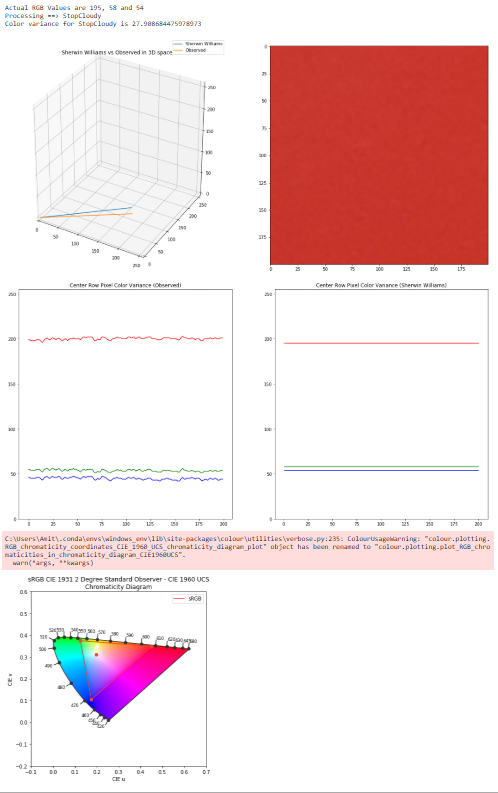          
"></img>

#### Code

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from ipywidgets import interact
import cv2
import matplotlib.pyplot as plt
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from mpl_toolkits.mplot3d import axes3d, Axes3D
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie1994
import pandas as pd
import colour.plotting
from ipywidgets import widgets
from IPython.display import display
import numpy as np

In [5]:
def process_image(color='None', env = 'None'):
    """
    This method is called by the interactive widget which will do out comparisions for us and prodice the grpahs that will display our color variations
    :color - The color swatch used in the input
    :env - The environmental condition under which the image was taken
    """
    if color == 'None' or env == 'None':
        print('Nothing to show')
        return
    # Get RGB Value for Sherwin Williams
    data = pd.read_excel('SummaryOfPictures4Project.xlsx')
#     filter = excel_data['Color']==color
    filtered_data = data[data['Color'] == color.strip()]
    actual_r, actual_g, actual_b = filtered_data.iloc[0, 2], filtered_data.iloc[0, 3], filtered_data.iloc[0, 4]
    print('Actual RGB Values are {}, {} and {}'.format(actual_r, actual_g, actual_b))
    color = color.replace(" ", "")
    image_file_name = color + env
    print('Processing ==> {}'.format(image_file_name))
    im = cv2.imread('data/' + image_file_name + ".jpg")
#     Refer: https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     actual_r, actual_g, actual_b = 167, 133, 167
    im = im[int(im.shape[0]/2)-100:int(im.shape[0]/2)+100,int(im.shape[1]/2)-100:int(im.shape[1]/2)+100]
    # Smoothing the image using Gaussian Blur
    im = cv2.GaussianBlur(im, (5,5),0)
    realr=np.array([actual_r]*200)
    realg=np.array([actual_g]*200)
    realb = np.array([actual_b]*200)
    center = im[int(im.shape[0]/2),:]
    
    center_pixel = im[int(im.shape[0]/2),int(im.shape[1]/2)]
    sherwin_williams_center_pixel = sRGBColor(actual_r, actual_g, actual_b);
    observed_center_pixel = sRGBColor(center_pixel[0], center_pixel[1], center_pixel[2]);
    # Convert from RGB to Lab Color Space (Refer: https://en.wikipedia.org/wiki/CIELAB_color_space)
    color1_lab = convert_color(sherwin_williams_center_pixel, LabColor);
    color2_lab = convert_color(observed_center_pixel, LabColor);

    # Find the color difference
    delta_e = delta_e_cie1994(color2_lab, color1_lab);

    print("Color variance for {} is {}".format(image_file_name, delta_e))
    
    cx = im[int(im.shape[0]/2),int(im.shape[1]/2),0]
    cy = im[int(im.shape[0]/2),int(im.shape[1]/2),1]
    cz = im[int(im.shape[0]/2),int(im.shape[1]/2),2]
    
    fig = plt.figure(0,(20,10))
    ax = fig.add_subplot(121, projection='3d')
    plt.xlim(0,255)
    plt.ylim(0,255)
    ax.set_zlim(0,255)
    ax.plot((0,actual_r),(0,actual_g),(0,actual_b), label = 'Sherwin Williams')

    ax.plot((0,cx),(0,cy),(0,cz), label = 'Observed')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.title('Sherwin Williams vs Observed in 3D space')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.imshow(im)
    
    plt.show()
    
    fig =plt.figure(0,(20,10))
    plt.subplot(1,2,1)
    plt.plot(center[:,0],color="red")
    plt.plot(center[:,1],color="green")
    plt.plot(center[:,2],color="blue")
    plt.ylim(0,255)
    plt.title('Center Row Pixel Color Variance (Observed)')
    
    points = np.linspace(1,200,200)
    plt.subplot(1,2,2)
    plt.plot(points, realr,color="red")
    plt.plot(points, realg,color="green")
    plt.plot(points, realb,color="blue")
    plt.ylim(0,255)
    plt.title('Center Row Pixel Color Variance (Sherwin Williams)')
    plt.show()
    SRGB = np.array([realr,realg,realb])
    colour.plotting.RGB_chromaticity_coordinates_CIE_1960_UCS_chromaticity_diagram_plot(SRGB,colorspace='sRGB')
    #SRGB = np.array([cx])
    

In [6]:

def prepare_dropdown():
    excel_data = pd.read_excel('SummaryOfPictures4Project.xlsx')
#     colors_series = excel_data['Color'].apply(lambda x: x.replace(" ", ""))
    colors_series = excel_data['Color']
    colors_list = list(colors_series)
    env_list = ['None','Cloudy','CloudyFlash','CloudyFluorescent']
    j = widgets.interactive(process_image, color=colors_list, env=env_list)
    display(j)
    


prepare_dropdown()

interactive(children=(Dropdown(description='color', options=('Stop', 'Invigorate', 'Osage Orange', 'Gusto Gold…

#### How much have we accomplished so far

From the perspective of what was asked of us from our industry partner we have accomlished all the goals set for us in our meeting. The goal being in what unique ways we can study variations between the Sherwin Williams standard and the observed color space under different lighting conditions. The goal being to help us understand how to meausre light's effect in color surfaces.

To add to our project, we hvae also incorporated the changes mentioned by the professor in our second stage project meeting. The goal being representing the the Observed and Sherwin williams coolr standard in the sRGB color space.

#### Conclusions


From our project we have learnt to use different standards to identify color variations in images. We hvae learnt how different lighting conditions can affect users perception of color and how this data can help indutry professionals who perform home renovations. We see other uses for this data such as online retailers selling clothes where the color shown on screen doesn't match the color the user receives which prompts a return to the online retailer costing them a lot of money. While there are many more techniques to study since color judgement is usually subjective we believe we have explored enough methods to shed some light to analysing the differences.